In [27]:
from tkinter import Variable
import gym
import time

import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.distributions import MultivariateNormal

import torch.nn.functional as F
import matplotlib.pyplot as plt

## Code

In [2]:
class Feedforward(nn.Module):
    """
    """
    def __init__(self, inp, out):
        super().__init__()
        self.layer1 = nn.Linear(inp, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, out)

    def forward(self, obs):
        """
        """
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float)

        out_layer1 = F.relu(self.layer1(obs))
        out_layer2 = F.relu(self.layer2(out_layer1))
        return self.layer3(out_layer2)

In [3]:
class PPO:
    """
        This is the PPO class we will use as our model in main.py
    """

    def __init__(self, policy_class, env, **hyperparameters):
        """
            Initializes the PPO model, including hyperparameters.
        """
        self.eval_actor_loss, self.critic_loss, self.eval_avgreturn = [], [], []
        self._init_hyperparameters(hyperparameters)

        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.shape[0]

        self.actor_network = policy_class(self.obs_dim, self.act_dim)                                                   # ALG STEP 1
        self.critic_network = policy_class(self.obs_dim, 1)
        self.actor_optim = Adam(self.actor_network.parameters(), lr=self.lr)
        self.critic_optim = Adam(self.critic_network.parameters(), lr=self.lr)

        self.cov_var = torch.full(size=(self.act_dim,), fill_value=0.5)
        self.cov_mat = torch.diag(self.cov_var)

        # This logger will help us with printing out summaries of each iteration
        self.logger = {
            'delta_t': time.time_ns(), 't_total': 0, 'i_total': 0,         
            'batch_lens': [], 'batch_rews': [], 'actor_losses': [], 'critic_losses':[]  
        }

    def train(self, total_steps):
        """
        """
        t_total ,i_total = 0,0 
        plot_observation = list()
        while t_total < total_steps:                                                        
            batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens = self.batch_simulator()                     
            t_total += np.sum(batch_lens)
            i_total += 1

            self.logger['t_total'] = t_total
            self.logger['i_total'] = i_total

            V, _ = self.evaluate(batch_obs, batch_acts)
            A_k = batch_rtgs - V.detach()                                                                      
            A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)

            for _ in range(self.n_updates_per_iteration):                                                       
                V, curr_log_probs = self.evaluate(batch_obs, batch_acts)
                ratios = torch.exp(curr_log_probs - batch_log_probs)
                surr1 = ratios * A_k
                surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * A_k
                actor_loss = (-torch.min(surr1, surr2)).mean()
                critic_loss = nn.MSELoss()(V, batch_rtgs)

                self.actor_optim.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.actor_optim.step()

                self.critic_optim.zero_grad()
                critic_loss.backward()
                self.critic_optim.step()

                self.logger['actor_losses'].append(actor_loss.detach())
                self.logger['critic_losses'].append(critic_loss.detach())

            self._log_summary()
            
            plot_observation.append(batch_obs)
            # Save our model
            if i_total % self.save_freq == 0:
                torch.save(self.actor_network.state_dict(), './ppo_actor.pth')
                torch.save(self.critic_network.state_dict(), './ppo_critic.pth')

        return self.eval_actor_loss, self.critic_loss, self.eval_avgreturn, plot_observation

    def batch_simulator(self):

        batch_obs = []
        batch_acts = []
        batch_log_probs = []
        batch_rews = []
        batch_rtgs = []
        batch_lens = []

        ep_rews = []

        t = 0
        while t < self.timesteps_per_batch:
            ep_rews = [] 
            obs = self.env.reset()
            done = False

            b_ob, b_act, b_log_prob, ep_rew, ep_t = self.episode_simulator(obs)
            t += ep_t
            # print(f"episode end {ep_t}")
            # print(f"total timestamp count: {t}")
            batch_obs.extend(b_ob)
            batch_acts.extend(b_act)
            batch_log_probs.extend(b_log_prob)
            batch_rews.append(ep_rew)
            batch_lens.append(ep_t+1)


        batch_obs = torch.tensor(batch_obs, dtype=torch.float)
        batch_acts = torch.tensor(batch_acts, dtype=torch.float)
        batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float)
        batch_rtgs = self.calc_rtgs(batch_rews)                                                             
        self.logger['batch_rews'] = batch_rews
        self.logger['batch_lens'] = batch_lens

        print( np.mean([np.sum(ep_rews) for ep_rews in self.logger['batch_rews']]))

        return batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens

    def episode_simulator(self, obs):

        b_obs, b_acts, b_log_probs, ep_rews = [], [], [], []
        for ep_t in range(self.max_timesteps_per_episode):
            
            # ti += 1 
            # print(f"total timestamp count: {ti}")
            # print(f"episodic count: {ep_t}")
            b_obs.append(obs)
            action, log_prob = self.action_sampler(obs)
            obs, rew, done, _ = self.env.step(action)
            
            ep_rews.append(rew)
            b_acts.append(action)
            b_log_probs.append(log_prob)

            if done:
                break
        
        return b_obs, b_acts, b_log_probs, ep_rews, ep_t

    def calc_rtgs(self, batch_rews):
        """
            Compute the Reward-To-Go 
        """
        batch_rtgs = []
        for ep_rews in reversed(batch_rews):

            discounted_reward = 0 
            for rew in reversed(ep_rews):
                discounted_reward = rew + discounted_reward * self.gamma
                batch_rtgs.insert(0, discounted_reward)
        batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)

        return batch_rtgs

    def action_sampler(self, obs):
        """
        """
        mean = self.actor_network(obs)
        dist = MultivariateNormal(mean, self.cov_mat)

        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.detach().numpy(), log_prob.detach()

    def evaluate(self, batch_obs, batch_acts):
        V = self.critic_network(batch_obs).squeeze()
        mean = self.actor_network(batch_obs)
        dist = MultivariateNormal(mean, self.cov_mat)
        log_probs = dist.log_prob(batch_acts)
        return V, log_probs

    def _init_hyperparameters(self, hyperparameters):
        self.timesteps_per_batch = 4800                 
        self.max_timesteps_per_episode = 1600           
        self.n_updates_per_iteration = 5                
        self.lr = 0.005                                
        self.gamma = 0.95                               
        self.clip = 0.2                                

        # Miscellaneous parameters
        self.render = True                             
        self.render_every_i = 10                       
        self.save_freq = 10                            
        self.seed = None                               

        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val))

        if self.seed != None:
            assert(type(self.seed) == int)
            torch.manual_seed(self.seed)
            print(f"Successfully set seed to {self.seed}")

    def _log_summary(self):
        delta_t = self.logger['delta_t']
        self.logger['delta_t'] = time.time_ns()
        delta_t = (self.logger['delta_t'] - delta_t) / 1e9
        delta_t = str(round(delta_t, 2))

        t_total = self.logger['t_total']
        i_total = self.logger['i_total']
        avg_ep_lens = np.mean(self.logger['batch_lens'])
        avg_ep_rews = np.mean([np.sum(ep_rews) for ep_rews in self.logger['batch_rews']])
        avg_actor_loss = np.mean([losses.float().mean() for losses in self.logger['actor_losses']])
        avg_critic_loss = np.mean([losses.float().mean() for losses in self.logger['critic_losses']])
        

        avg_ep_lens = str(round(avg_ep_lens, 2))
        avg_ep_rews = str(round(avg_ep_rews, 2))
        avg_actor_loss = str(round(avg_actor_loss, 5))
        avg_critic_loss = str(round(avg_critic_loss, 5))


        print(flush=True)
        print(f"-------------------- Iteration #{i_total} --------------------", flush=True)
        print(f"Average Episodic Length: {avg_ep_lens}", flush=True)
        print(f"Average Episodic Return: {avg_ep_rews}", flush=True)
        print(f"Average Actor Loss: {avg_actor_loss}", flush=True)
        print(f"Average Critic Loss: {avg_critic_loss}", flush=True)
        print(f"Timesteps So Far: {t_total}", flush=True)
        print(f"Iteration took: {delta_t} secs", flush=True)
        print(f"------------------------------------------------------", flush=True)
        print(flush=True)

        self.logger['batch_lens'], self.logger['batch_rews'], self.logger['actor_losses'], self.logger['critic_losses'] = [],[],[],[]

        self.eval_actor_loss.append(avg_actor_loss)
        self.eval_avgreturn.append(avg_ep_rews)
        self.critic_loss.append(avg_critic_loss)

## Implementation 

In [4]:
env = gym.make('Pendulum-v1')
model = PPO(Feedforward, env)
actor_loss, c_loss, avg_return, observations = model.train(450000)

-1197.906257607328

-------------------- Iteration #1 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1197.91
Average Actor Loss: 0.0138
Average Critic Loss: 13109.857
Timesteps So Far: 5000
Iteration took: 3.09 secs
------------------------------------------------------



C:\Users\ankur\AppData\Local\Temp\ipykernel_31432\2138121446.py:105: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  batch_obs = torch.tensor(batch_obs, dtype=torch.float)


-1339.6047218702267

-------------------- Iteration #2 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1339.6
Average Actor Loss: 0.00042
Average Critic Loss: 15670.975
Timesteps So Far: 10000
Iteration took: 2.98 secs
------------------------------------------------------

-1395.7338920670768

-------------------- Iteration #3 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1395.73
Average Actor Loss: -0.00089
Average Critic Loss: 16214.722
Timesteps So Far: 15000
Iteration took: 2.99 secs
------------------------------------------------------

-1290.5162302655995

-------------------- Iteration #4 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1290.52
Average Actor Loss: -0.00099
Average Critic Loss: 12306.718
Timesteps So Far: 20000
Iteration took: 2.93 secs
------------------------------------------------------

-1328.3680517681166

-------------------- Iteration #5 --------------------
Avera

------------------------------------------------------

-866.9764986757941

-------------------- Iteration #29 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -866.98
Average Actor Loss: -0.00213
Average Critic Loss: 562.53644
Timesteps So Far: 145000
Iteration took: 3.0 secs
------------------------------------------------------

-872.9094047011827

-------------------- Iteration #30 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -872.91
Average Actor Loss: -0.00081
Average Critic Loss: 564.5251
Timesteps So Far: 150000
Iteration took: 3.0 secs
------------------------------------------------------

-898.7497182208758

-------------------- Iteration #31 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -898.75
Average Actor Loss: -0.00174
Average Critic Loss: 525.51385
Timesteps So Far: 155000
Iteration took: 3.03 secs
------------------------------------------------------

-803.1467416696771

------

Timesteps So Far: 275000
Iteration took: 3.43 secs
------------------------------------------------------

-234.85103640086288

-------------------- Iteration #56 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -234.85
Average Actor Loss: -0.00354
Average Critic Loss: 34.69406
Timesteps So Far: 280000
Iteration took: 3.46 secs
------------------------------------------------------

-183.23275581083396

-------------------- Iteration #57 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -183.23
Average Actor Loss: -0.00121
Average Critic Loss: 26.75826
Timesteps So Far: 285000
Iteration took: 3.4 secs
------------------------------------------------------

-161.91361779236652

-------------------- Iteration #58 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -161.91
Average Actor Loss: -0.00084
Average Critic Loss: 19.2966
Timesteps So Far: 290000
Iteration took: 3.61 secs
------------------------------

Average Actor Loss: -0.0022
Average Critic Loss: 15.01878
Timesteps So Far: 410000
Iteration took: 3.04 secs
------------------------------------------------------

-185.07917987618305

-------------------- Iteration #83 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -185.08
Average Actor Loss: -0.00182
Average Critic Loss: 16.72386
Timesteps So Far: 415000
Iteration took: 3.09 secs
------------------------------------------------------

-143.76825466480113

-------------------- Iteration #84 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -143.77
Average Actor Loss: -0.001
Average Critic Loss: 19.39131
Timesteps So Far: 420000
Iteration took: 3.07 secs
------------------------------------------------------

-149.00501509082585

-------------------- Iteration #85 --------------------
Average Episodic Length: 200.0
Average Episodic Return: -149.01
Average Actor Loss: -0.00171
Average Critic Loss: 13.88382
Timesteps So Far: 42500

In [9]:
observations = [i.numpy() for i in observations]

In [71]:
observation_cos = [[i[0] for i in obs] for obs in observations]
observation_sin = [[i[1] for i in obs] for obs in observations]
torque = [[i[2] for i in obs] for obs in observations]

In [72]:
x = [observation_cos[89][i:i + 200] for i in range(0, len(observation_cos[89]), 200)]
y = [observation_sin[89][i:i + 200] for i in range(0, len(observation_sin[89]), 200)]
z = [torque[89][i:i + 200] for i in range(0, len(torque[89]), 200)]

cos_theta_plot = pd.DataFrame(x).T
sin_theta_plot = pd.DataFrame(y).T
z = pd.DataFrame(z).T

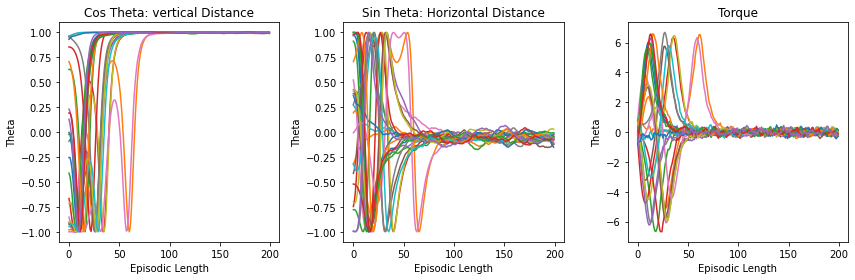

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax[0].plot(cos_theta_plot)
ax[1].plot(sin_theta_plot)
ax[2].plot(z)

ax[0].set_title("Cos Theta: vertical Distance")
ax[1].set_title("Sin Theta: Horizontal Distance")
ax[2].set_title("Torque")

for a in ax:
    a.set_xlabel("Episodic Length")
    a.set_ylabel("Theta")

fig.tight_layout()
plt.show()

In [5]:
t = pd.DataFrame([actor_loss, c_loss, avg_return], index=["Actor Loss", "Critic Loss", "Avg. Return"]).T
t= t.apply(pd.to_numeric, errors='coerce')

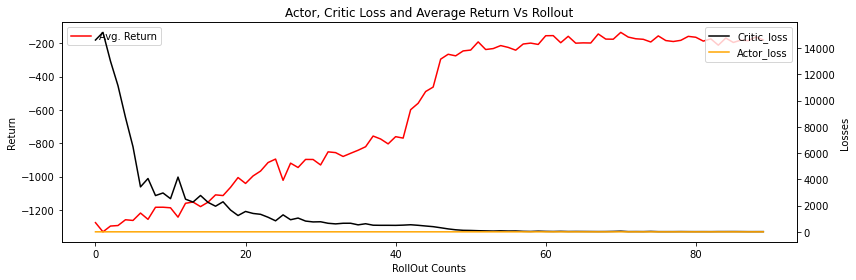

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
ax_right = ax.twinx()
ax_right.plot(t['Critic Loss'], color='black', label='Critic_loss')
ax_right.plot(t['Actor Loss'], color='orange', label='Actor_loss')
ax.plot(t['Avg. Return'], color='red', label='Avg. Return')
ax.set_title("Actor, Critic Loss and Average Return Vs Rollout")
ax.set_xlabel("RollOut Counts")
ax.set_ylabel("Return")
ax_right.set_ylabel("Losses")


ax.legend()
ax_right.legend()

fig.tight_layout()
plt.show()